<a href="https://colab.research.google.com/github/nrodas1999/X.C51/blob/main/Pset2_Frida_Nicole_Angehrn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <center> Problem Set 2 <center>
<center> 3.C01/3.C51, 7.C01/7.C51, 10.C01/10.C51, 20.C01/20.C51<center>

<b>Name:</b>

<b>Kerberos id:</b>

### Download required data & install packages

In [1]:
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps2-bio/data/dna_binding.csv
!wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps2-bio/data/cell_segmentation_jpeg.tar.gz
!tar -xf cell_segmentation_jpeg.tar.gz

--2025-04-11 09:00:10--  https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps2-bio/data/dna_binding.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1408340 (1.3M) [text/plain]
Saving to: ‘dna_binding.csv.3’

dna_binding.csv.3   100%[===================>]   1.34M  --.-KB/s    in 0.008s  

2025-04-11 09:00:10 (164 MB/s) - ‘dna_binding.csv.3’ saved [1408340/1408340]

--2025-04-11 09:00:10--  https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps2-bio/data/cell_segmentation_jpeg.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision.models import vgg16
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.utils import shuffle
from sklearn import preprocessing
import glob

import os
import PIL
from PIL import Image
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import imageio
from skimage import io, color



matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

## <center>Problem 1: Predicting DNA Binding Sites</center>

In [3]:
df = pd.read_csv("./dna_binding.csv")

sequences = df.seq.values
y = df.bind.values


### 1.1 (20 points) Build Datasets and DataLoaders in PyTorch

One-hot encode DNA sequence data.

In [4]:
def SeqEnc(sequences):
    '''
    A function to one-hot encode DNA sequences

    Args:
        sequences (list): list of DNA sequences

    Returns:
        np.array: array with shape (N,C,4) where N is the number of sequences
        and C is the sequence length
    '''
    ################ Code #################
    nucleotides = ['A', 'C', 'G', 'T']
    encoded_sequences = []
    for sequence in sequences:
        encoded_sequence = []
        for nucleotide in sequence:
            encoding = [0, 0, 0, 0]
            if nucleotide == 'A':
                encoding = [1, 0, 0, 0]
            elif nucleotide == 'C':
                encoding = [0, 1, 0, 0]
            elif nucleotide == 'G':
                encoding = [0, 0, 1, 0]
            elif nucleotide == 'T':
                encoding = [0,  0, 0, 1]
            encoded_sequence.append(encoding)
        encoded_sequences.append(np.array(encoded_sequence))
    return np.array(encoded_sequences)
    ################ Code #################
X = SeqEnc(sequences)
print(X.shape)

(12904, 101, 4)


Implement your dataset class that takes in your data.

In [5]:
# Generate dataset
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))
        self.y = torch.Tensor(np.array(y))
        self.len=len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

Define your Datasets and DataLoaders.

In [6]:
# Define dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

#Build Dataset
train_data = SequenceDataset(X_train, y_train)
val_data = SequenceDataset(X_val, y_val)
test_data = SequenceDataset(X_test, y_test)

# Build DataLoader
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

#just checking, copied from Pset1 :)
for loader in [train_loader, val_loader, test_loader]:
    for index, batch in enumerate(loader):
        # Your batch returns a X, y stacked in a batch
        X_batch, y_batch = batch[0], batch[1]
        print(X_batch.shape, y_batch.shape)
    print()

torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.Size([256])
torch.Size([256, 101, 4]) torch.

What is the benefit of batching your data into mini-batches versus using the entire dataset to optimize the model all at once?

In [7]:
################ Answer #################
print('The benefits can be separated in two categories')
print('Optimization:\n when separating in batches we have advantages in not having all values saved at once and we can also optimize time by \n parellelizing the algorithm and this can maybe even cause the system to converge faster because the gradients get \n updated with every smaller step'  )
print('Model improvements:\n training smaller batches causes the regularization to be better optimized as it gets updated with evry batch, \n in a way it gets fine tuned.\n Similarly doing multiple parameter optimizations in every batch can give a more generalizable model.')
################ Answer #################

The benefits can be separated in two categories
Optimization:
 when separating in batches we have advantages in not having all values saved at once and we can also optimize time by 
 parellelizing the algorithm and this can maybe even cause the system to converge faster because the gradients get 
 updated with every smaller step
Model improvements:
 training smaller batches causes the regularization to be better optimized as it gets updated with evry batch, 
 in a way it gets fine tuned.
 Similarly doing multiple parameter optimizations in every batch can give a more generalizable model.


### 1.2 (20 points) Build an LSTM-based binding classifier

The following example will help familiarize you with the LSTM.

In [7]:
# Define a LSTM module
lstm_model = nn.LSTM(input_size=4, hidden_size=16, num_layers=1, batch_first=True, bidirectional=True).to("cpu") # "cpu" is the device id

# Send your batch to a GPU
X_batch, y_batch = next(iter(train_loader))
X_batch = X_batch.to("cpu")
y_batch = y_batch.to("cpu")

# Propagate your batch into your model
lstm_out, (ht, ct) = lstm_model(X_batch)
print(lstm_out.shape, ht.shape, ct.shape)

# You can play with hyperparameters to see how your output change

torch.Size([256, 101, 32]) torch.Size([2, 256, 16]) torch.Size([2, 256, 16])


Now build your LSTM-based classifier as a nn.Module.

In [8]:
class LSTMseq(torch.nn.Module) :
    def __init__(self, input_dim, hidden_dim) :
        super().__init__()

        # Define a LSTM module
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=True)

        # Define a MLP regressor
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        # Define a sigmoid transform
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # Apply LSTM
        hT, (ht, ct) = self.lstm(x)

        # Pass output into a MLP
        out = self.mlp(hT[:,-1,:])

        # Transform output into probabilites
        proba = self.sigmoid(out)

        # Return probabilities
        return proba

In [9]:
# Test your ouput on a batch
clf = LSTMseq(input_dim=4, hidden_dim=16).to('cpu')
print(clf(X_batch).shape)

torch.Size([256, 1])


### 1.3 (20 points) Implement functions for training and testing

The training and validation loops and evaluation function.

In [10]:
#I used AI to debug this part, most importantly I had mistakes in the validate and evaluate steps. It also added the squeeze in the training
def train(model, dataloader, optimizer, device):

    '''
    A function to train on the entire dataset for one epoch.

    Args:
        model (torch.nn.Module): Your sequence classifier
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization
        device (str): Your device

    Returns:
        float: loss averaged over all the batches

    '''

    batch_loss = []
    model.train() # Set model to training mode

    for batch in dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        y_pred = model(seq)

        # Compute loss
        loss = nn.functional.binary_cross_entropy(y_pred.squeeze(), label.squeeze())
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())

    return np.mean(batch_loss)


def validate(model, dataloader, device):

    '''
    A function to validate on the validation dataset for one epoch.

    Args:
        model (torch.nn.Module): Your sequence classifier
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device

    Returns:
        float: loss averaged over all the batches

    '''

    val_loss = []
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)

            # validate your model on each batch here
            y_pred = model(seq)

            # Compute loss
            loss = nn.functional.binary_cross_entropy(y_pred.squeeze(), label.squeeze())

            val_loss.append(loss.item())

    return np.mean(val_loss)

def evaluate(model, dataloader, device):

    '''
    A function to return the classification probabilities and true labels (for evaluation).

    Args:
        model (torch.nn.Module): your sequence classifier
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        device (str): Your device

    Returns:
        (np.array, np.array): true labels, predicted probabilities
    '''

    pred_prob = []
    labels = []
    with torch.no_grad():
        model.eval()
        for batch in dataloader:
            epoch_loss = []
            seq, label = batch

            seq = seq.to(device)
            label = label.to(device).cpu().numpy() #AI used, remindede me to transfer to cpu and make int numpy array

            y_pred = model(seq).cpu().numpy()
            pred_prob.extend(y_pred)
            labels.extend(label)

    return labels, pred_prob

In [11]:
device = 'cuda:0'
model = LSTMseq(4, 16).to(device)

optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.5)

val_loss_curve = []
train_loss_curve = []

# Use tqdm for progress bar
tqdm_progress =  tqdm(range(500), desc="Progress")

for epoch in tqdm_progress:
    # Compute train your model on training data
    epoch_loss = train(model, train_loader, optimizer,  device=device)

    # Validate your on validation data
    val_loss = validate(model, val_loader, device=device)

    # Record train and loss performance
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)

    # The learning rate scheduler record the validation loss
    scheduler.step(val_loss)
    tqdm_progress.set_postfix(train_loss=f'{epoch_loss:.3f}', val_loss=f'{val_loss:.3f}', refresh=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Progress: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s, train_loss=0.118, val_loss=0.291]


Plot train and validation loss functions.

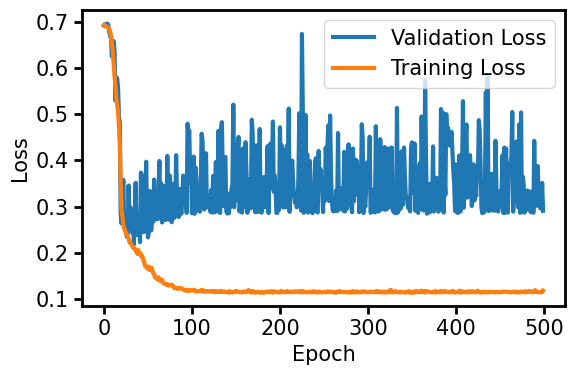

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(val_loss_curve, label='Validation Loss')
ax.plot(train_loss_curve, label='Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
fig.tight_layout()

Report the AUC on test data.


In [15]:
################ Code #################
test_labels, test_pred_prob = evaluate(model, test_loader, device)
auc = roc_auc_score(test_labels, test_pred_prob)
print(f'AUC: {auc}')
################ Code #################

AUC: 0.9428111545435647


## Problem 2: Image Segmentation

### 2.1 (20 points) Build Datasets and DataLoaders

Parse data from image filepaths.

In [22]:
paths = [path for path in glob.glob("cell_segmentation/*") if "cells" in path]

def load_img(path):
    x = np.array(Image.open(path)) / 255
    y = np.array(Image.open(path.replace("cells","masks"))) / 255
    return x, y

Load one image.


(256, 256) (256, 256)


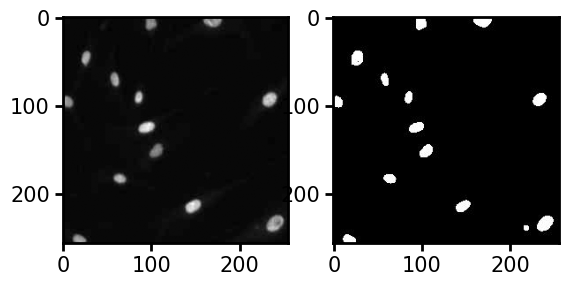

In [23]:
idx = 20
cells, masks = load_img(paths[idx])
fig, axes = plt.subplots(1,2)
axes[0].imshow(cells, cmap='gray')
axes[1].imshow(masks, cmap='gray')

print(cells.shape, masks.shape)

Your ImageDataset class.

In [24]:
################ Code #################
class ImageDataset(Dataset):
  def _init_(self,images,masks):
    self.images=images
    self.masks=masks

  def _getitem_(self,idx):
    image=self.images[idx]
    mask=self.masks[idx]
    return torch.tensor(image),torch.tensor(mask)
    #unsqueeze and torch tensor were debugging done by AI
  def _len_(self):
    return len(self.images)

Split your data and load your DataLoaders.


In [26]:
################ Code #################
#AI generated for debugging
cells_list = []
masks_list = []
for path in paths:
  cells, masks = load_img(path) # loading all data
  cells_list.append(cells)
  masks_list.append(masks)

#copied and adapted from part 1
X_train, X_test, y_train, y_test = train_test_split(cells_list, masks_list, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=0)

#Build Dataset
train_data = SequenceDataset(X_train, y_train)
val_data = SequenceDataset(X_val, y_val)
test_data = SequenceDataset(X_test, y_test)

# Build DataLoader
batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

#just checking, copied from Pset1 :)
for loader in [train_loader, val_loader, test_loader]:
    for index, batch in enumerate(loader):
        # Your batch returns a X, y stacked in a batch
        X_batch, y_batch = batch[0], batch[1]
        print(X_batch.shape, y_batch.shape)
    print()

torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
torch.Size([

Is it necessary to apply random translation to your images? Briefly justify your answer.


In [27]:
############### Answer #################
print('No, CNNs are translation invariant.\nThis is because the layers in cnns are scanned by the convolutional layer which is small and goes through all the image.\nSo the features get detected no matter where they are, \nso a shift in my image will still mark the feature and the same amount of features. ')
############################### Answer #################

No, CNNs are translation invariant.
This is because the layers in cnns are scanned by the convolutional layer which is small and goes through all the image.
So the features get detected no matter where they are, 
so a shift in my image will still mark the feature and the same amount of features. 


### 2.2 (20 points) Train a U-Net Model that Performs Image Segmentation

Implement Dice loss.

In [37]:
def dice_loss(pred, target):
    """Calculate Dice loss.

    Parameters
    ----------
        pred:
            predictions from the model
        target:
            ground truth label
    """

################ Code #################
    intersec = (pred.flatten()*target.flatten()).sum(dim=0)
    sum = pred.flatten().sum(dim=0) + target.flatten().sum(dim=0)
    loss = 1-(2*intersec+1)/(sum+1)
    return loss.mean()

The U-Net Model.


In [38]:
class DownSampling(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, name=None):
        super(DownSampling, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):

        conv_out = self.conv(x)
        output = self.max_pool(conv_out)

        return output, conv_out


class UpSampling(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, name=None):
        super(UpSampling, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size)
        self.conv_t = nn.ConvTranspose2d(out_channels, out_channels, kernel_size, \
                                         padding=1, stride=2, output_padding=1)


    def forward(self, x, skip):

        conv_out = self.conv(x)
        output = self.conv_t(conv_out)

        output += skip

        return output


class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, padding=1, stride=1, name=None):
        super(ConvBlock, self).__init__()

        block = []
        # first conv layer
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size, \
                               padding=padding, stride=stride))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_channels))

        # second conv layer
        block.append(nn.Conv2d(out_channels, out_channels, kernel_size, \
                               padding=padding, stride=stride))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_channels))

        # make sequential
        self.conv_block = nn.Sequential(*block)


    def forward(self, x):

        output = self.conv_block(x)

        return output


class UNet(nn.Module):

    def __init__(self, num_kernel=8, kernel_size=3, dim=1, target_dim=1):
        """UNet

        Arguments:
            num_kernel: int
                number of kernels to use for the first layer
            kernel_size: int
                size of the kernel for the first layer
            dims: int
                number of color channels for input images
            target_dim: int
                number of channels for the output mask
        """

        super(UNet, self).__init__()

        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = 1

        # encode
        self.encode_1 = DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):

        has_channel = x.ndim == 4
        if not has_channel:
            x = x.unsqueeze(1)

        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)

        pred = self.activate(x)

        if not has_channel:
            pred = pred.squeeze(1)

        return pred


    def args_dict(self):
        """model arguments to be saved
        """

        model_args = {'dim': self.dim,
                      'target_dim': self.target_dim,
                      'num_kernel' : self.num_kernel,
                      'kernel_size' : self.kernel_size}

        return model_args

Example model usage.

In [39]:
model = UNet()
y = model(torch.randn(4, 256, 256))

print(y.shape)

torch.Size([4, 256, 256])


A function to plot a segmentation map.


In [40]:
def plot_seg(img, pred_seg, true_seg, mask_cutoff=0.5):

    """ Visualize segmentation results.
    Inputs:
        image: orginal image, shape: 256 x 256
        pred_seg: predicted mask, shape: 256 x 256
        true_seg: true mask, shape: 256 x 256
        mask_cutoff: if the mask values is larger than mask_cutoff, the mask will appear on the image
    """
    img = img.squeeze()
    pred_seg = pred_seg.squeeze()
    true_seg = true_seg.squeeze()

    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
    fig.set_size_inches((15,15))

    ax[0].set_title("Original Image")
    ax[1].set_title("Prediction")
    ax[2].set_title("Ground Truth")

    img = np.stack([img,img,img],axis = -1)
    ax[0].imshow(img)
    ax[1].imshow(np.clip(color.label2rgb(pred_seg > mask_cutoff,img,colors=[(255,0,0)],alpha=0.0025, bg_label=0, bg_color=None),0,1))
    ax[2].imshow(np.clip(color.label2rgb(true_seg > mask_cutoff,img,colors=[(255,0,0)],alpha=0.0025, bg_label=0, bg_color=None),0,1))

    plt.show()

Train your model.

In [42]:
################ Code #################
def train(model, dataloader, optimizer, device):
    model.train()
    batch_loss = []
    for batch in dataloader:
      images, masks = batch
      images = images.float().to(device)
      masks = masks.float().to(device)

      optimizer.zero_grad()
      y_pred = model(images)
      loss = dice_loss(y_pred, masks)
      loss.backward()
      optimizer.step()
      batch_loss.append(loss.item())

    return np.mean(batch_loss)

def validate(model, dataloader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
      for batch in dataloader:
        images, masks = batch
        images = images.float().to(device)
        masks = masks.float().to(device)

        y_pred = model(images)
        loss = dice_loss(y_pred, masks)
        val_loss.append(loss.item())
    return np.mean(val_loss)

def evaluate(model, dataloader, device):
    model.eval()
    pred_seg = []
    true_seg = []

    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch
            images = images.float().to(device)
            masks = masks.float().to(device)

            y_pred = model(images)
            pred_seg.extend(y_pred.cpu().numpy())
            true_seg.extend(masks.cpu().numpy())

    return np.array(pred_seg), np.array(true_seg)

device = 'cuda:0'
model = UNet().to(device)
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)

#copied from above
# Use tqdm for progress bar
tqdm_progress =  tqdm(range(40), desc="Progress")

for epoch in tqdm_progress:
    # Compute train your model on training data
    epoch_loss = train(model, train_loader, optimizer,  device=device)

    # Validate your on validation data
    val_loss = validate(model, val_loader, device=device)

Progress: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Show segmentation results for 3 images from the test dataset.


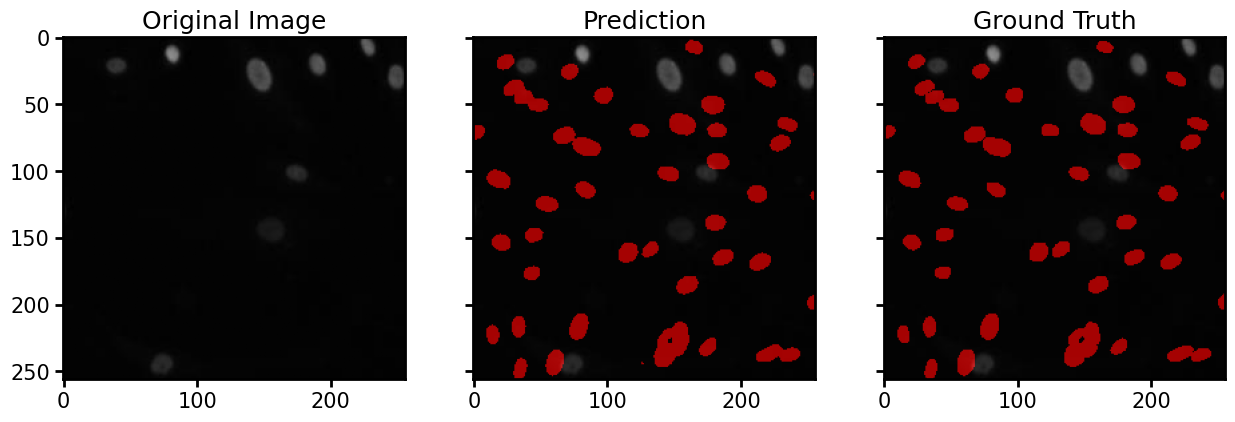

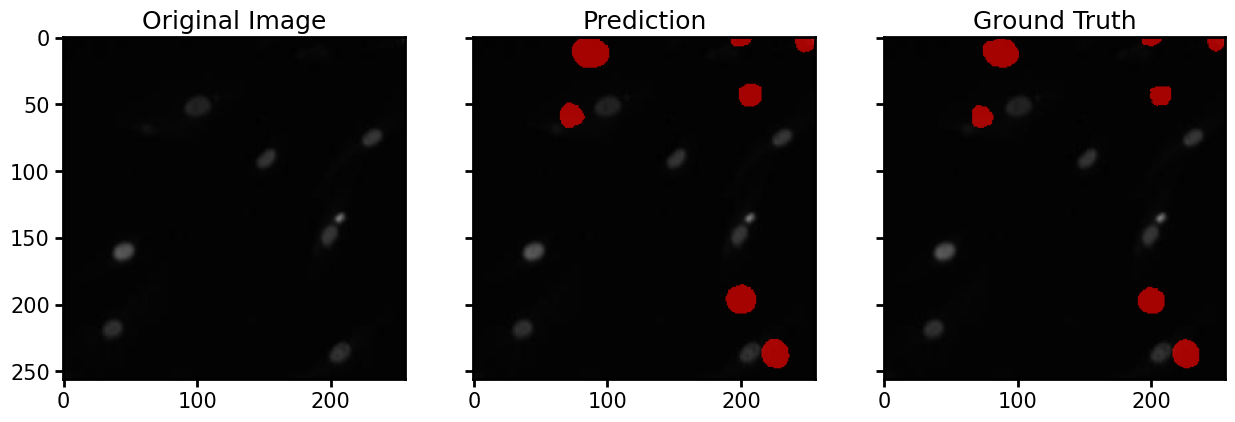

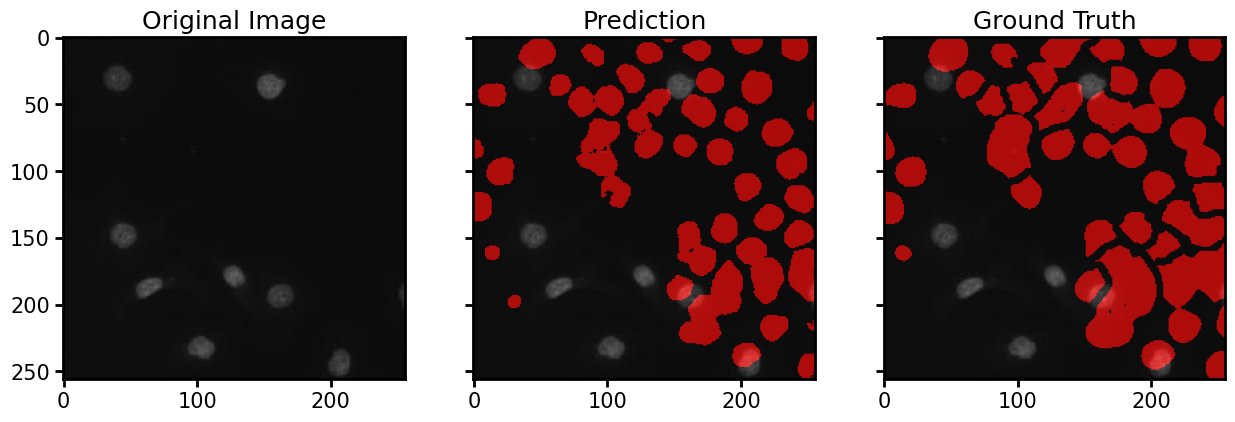

In [46]:
################ Code ###############
pred_segs, true_segs = evaluate(model, test_loader, device)
for batch in test_loader:
    images, masks = batch
    original_images = images.cpu().numpy()
for i in range(min(3, len(original_images))):
    plot_seg(original_images[i], pred_segs[i], true_segs[i])


Gemini was used in the positions that were indicated above, additionally sometimes the integrated gemini autofill was used for repetitive lines. I am not very good in Python so overall it also helps me with the syntax.
